## Earthquake Data Analysis

### Description

The catalog includes the magnitude, time of occurrence (s), and 3D coordinates (m) of earthquakes in about 20 years of recording in South California. Coordinates were converted from latitude, longitude, and depth of events in a seismic catalog. Magnitudes should be within the range $[0,8]$.

* **Waiting time (t)**: time interval between an event and the next one in the sequence.
* **Distance (r)**: Eucledian 3D distance between events. (each 3D set of coordinates refers to the hypocenter, i.e. the point triggering the slip in a fault that forms the earthquake)


### Assignments

1. Deduce what is the variable in each column of the catalog.
2. Visualize the process in space and/or time with suitable time series and/or 3D visualizations of the hypocenters. For instance, plot a space variable (a single coordinate or a nice linear combination of coordinates) as a function of time.
3. Compute the distribution $P_m(t)$ of waiting times for events of magnitude m or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$.
4. Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude m or above. Also here make a clever choice for the bin sizes and try several values of $m$.
5. Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. (In this statistics, if the following event is farther than $R$, skip the $t$ and go to the next pair)
6. Eventually note if, from the analysis of the previous points, there emerges a scaling picture. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 5 is considered) on a single curve?

### Datasets

* column 1: index of the event
* column 2: index of the previous event that triggered it (defined with a given algorithm), -1 if no ancestor is found
* column 3: time (seconds) from 0:00 of Jan.1st, 1982
* column 4: magnitude
* columns 5, 6, and 7: 3D coordinates (meters) of the earthquake hypocenter, i.e. of the point from where it started. These Euclidean coordinates are derived from latitude, longitude and depth.

Joining each event to that with the index of the second column (if not -1), there emerges a set of causal trees.

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
from IPython.display import Image
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
import graphviz
from datetime import timedelta
import math
from scipy import optimize
from scipy import stats
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import timedelta, datetime
from mycolorpy import colorlist as mcp

######## UNCOMMENT BELOW TO USE INTERACTIVE BOKEH PLOT #######
#    from bokeh.tile_providers import CARTODBPOSITRON, get_provider,STAMEN_TERRAIN,OSM
#    from bokeh.transform import factor_cmap, factor_mark, linear_cmap, log_cmap
#    from bokeh.plotting import figure, show, output_file
#    import bokeh.io #import output_notebook
#    from bokeh.io import output_notebook
#    import pandas_bokeh
#    from bokeh.palettes import Inferno
#    from bokeh.palettes import Set1
#    bokeh.io.reset_output()
#    bokeh.io.output_notebook()

%matplotlib inline


In [2]:
######## HTML SCRIPT TO HIDE CODE CELLS #######


from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)


## Dataset overview
We imported the dataset into a Pandas dataframe and associated a label with each column. We sorted the data by time as there were indices that did not match the chronological order of events.

In [3]:
hide_toggle(for_next=True)

In [4]:
# get dataset and sort by time
data = np.genfromtxt('SouthCalifornia-1982-2011_Physics-of-Data.dat')
df = pd.DataFrame(data, columns=['index', 'trigger', 'time', 'magnitude', 'X', 'Y', 'Z'])
df = df.sort_values(by=['time'])

The dataset presents the 3D Cartesian coordinates (x,y,z) of earthquake hypocenters converted from latitude, longitude, and event depth in a seismic catalog. In order to recover the original spherical coordinates, we used the following formulas:

* longitude: $\theta = \tan^{-1}(\frac{y}{x})$ with range [-180°, +180°]
* latitude: $\phi = \sin^{-1}(\frac{z}{r})$ with range [-90°, 90°]
* depth: $d = r - R$ with range [-R,0], where $r = \sqrt{x^2 + y^2 + z^2 }$ and $R$ is the average Earth's radius

We made this choice for the range of the depth because it is physically more significant since deeper earthquake hypocenters are associated with more negative values calculated with respect to the Earth's surface.

In [5]:
hide_toggle(for_next=True)

In [6]:
# transformation from Cartesian to spherical coordinates
R = 6371500 # Earth's radius
df["longitude"] = np.arctan2(df["Y"],df["X"])*180/np.pi
df["latitude"] = np.arcsin(df["Z"]/np.sqrt(df["X"]**2+df["Y"]**2+df["Z"]**2))*180/np.pi
df["depth"] = np.sqrt(df["X"]**2+df["Y"]**2+df["Z"]**2) - R

# convert time from seconds to years
df['date'] = pd.to_datetime(df['time'], unit='s', origin='01/01/1982')

df.head(10)


,index,trigger,time,magnitude,X,Y,Z,longitude,latitude,depth,date
0,0.0,-1.0,0.00000,2.71,-2571956.0,-4627162.0,3520602.0,-119.067002,33.624997,-13809.831190,1982-01-01 00:00:00.000000
1,1.0,0.0,36501.39072,2.12,-2363740.0,-4787011.0,3461373.0,-116.279332,32.957092,-8808.419635,1982-01-01 10:08:21.390720
2,2.0,0.0,37488.27744,2.33,-2363746.0,-4786942.0,3461232.0,-116.279718,32.956316,-8934.808059,1982-01-01 10:24:48.277440
3,3.0,0.0,47982.51648,2.57,-2475085.0,-4664024.0,3548479.0,-117.953814,33.903121,-9828.140870,1982-01-01 13:19:42.516480
4,4.0,0.0,60268.57056,2.98,-2238642.0,-4839098.0,3469546.0,-114.825995,33.053002,-10200.061789,1982-01-01 16:44:28.570560
5,5.0,0.0,100612.80864,2.04,-2545592.0,-4588519.0,3597315.0,-119.020383,34.432610,-9486.132281,1982-01-02 03:56:52.808640
6,6.0,0.0,106358.95296,2.27,-2361034.0,-4748837.0,3502194.0,-116.435716,33.439538,-16085.205090,1982-01-02 05:32:38.952960
7,7.0,0.0,127529.37216,2.64,-2484433.0,-4558759.0,3679010.0,-118.589506,35.322173,-8339.972807,1982-01-02 11:25:29.372160
8,8.0,0.0,130364.57088,2.62,-2429713.0,-4582352.0,3681247.0,-117.933999,35.365332,-11229.990851,1982-01-02 12:12:44.570880
9,9.0,0.0,134132.56128,2.48,-2526232.0,-4571575.0,3618942.0,-118.924844,34.716838,-17140.292066,1982-01-02 13:15:32.561280


## Data visualization
We have projected the hypocenters of earthquakes in a 2D and 3D plot over the map of California, using the Mercator transform. We have decided to display only earthquakes of magnitude $m > 3$ to avoid the extreme overlap given by all the earthquakes in the dataset.

In [7]:
hide_toggle(for_next=True)

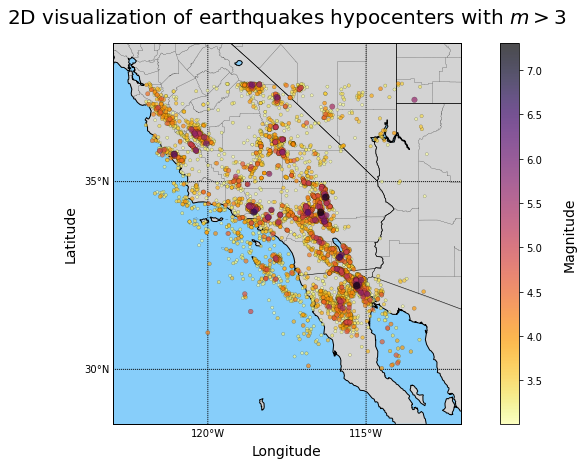

In [8]:
df = df.sort_values(by=['magnitude'])

fig, ax = plt.subplots(figsize=(14,7))
extent = [-123,-112,28.5,38.5]

# type of projection and latitude-longitude ranges of the map
my_map = Basemap(
    projection='merc',
    resolution = 'i',
    llcrnrlon=extent[0], llcrnrlat=extent[2],
    urcrnrlon=extent[1], urcrnrlat=extent[3])

my_map.drawcoastlines() # basic
my_map.fillcontinents(color='lightgrey',lake_color='lightskyblue') # distinguish continents and oceans
my_map.drawcountries() # distinguish the USA and Mexico
my_map.drawmapboundary(fill_color='lightskyblue') # ocean
my_map.drawstates() # distinguish states of the USA
my_map.drawcounties() # distinguish counties of the states of the USA
#my_map.bluemarble() # satellite

# draw parallels and meridians
my_map.drawparallels(np.arange(20,50,5), labels=[1,0,0,0])
my_map.drawmeridians(np.arange(-130,-100,5), labels=[0,0,0,1])

magn = 3

# conversion of latitude and longitude
lon = df['longitude'][df['magnitude']>magn]
lat = df['latitude'][df['magnitude']>magn]
depth = df['depth'][df['magnitude']>magn]
xm, ym = my_map(lon, lat)

# 2D plot
xy2d = my_map.scatter(xm, ym,
                      s=df['magnitude'][df['magnitude']>magn]**2,
                      c=df["magnitude"][df['magnitude']>magn],
                      cmap='inferno_r', edgecolor='k', linewidth=0.2, alpha=0.7,
                      zorder=2)

# colorbar, title and axes
cb = plt.colorbar(xy2d, ax=ax)
cb.set_label(label='Magnitude', fontsize=14, labelpad=20)
ax.set_title('2D visualization of earthquakes hypocenters with $m>{}$'.format(magn), fontsize=20, pad=20)
ax.set_xlabel('Longitude', fontsize=14, labelpad=20)
ax.set_ylabel('Latitude', fontsize=14, labelpad=35)

plt.show()

df = df.sort_values(by=['time'])

In [10]:
hide_toggle(for_next=True)

In [ ]:
######## UNCOMMENT BELOW TO USE INTERACTIVE BOKEH PLOT #######


""" from pyproj import Transformer

    TRAN_4326_TO_3857 = Transformer.from_crs("EPSG:4326", "EPSG:3857")

    def mytransform(lat, lon):
      return TRAN_4326_TO_3857.transform(lat, lon)

    tile_provider = get_provider(OSM)
    x_range, y_range = (-13600000, -12500000), (3480000, 4500000)
    p1 = figure(x_range=x_range, y_range=y_range,
               x_axis_type='mercator', y_axis_type='mercator', title='Earthquakes in Southern California')
    p1.add_tile(tile_provider)
    p1.title.text_font_size = "28px"
    p1.title.text_font = 'sans-serif'
    p1.title.text_font_style = 'normal'

    # creating a copy of the data for plotting
    df1 = df.sort_values(by='magnitude') # sorting w.r.t. magnitude for better visualization
    df1['magnitude'] = df1['magnitude'].round(0) # round magnitude values
    df1['mark_size'] = df1['magnitude']**1.4
    df1['alpha'] = df1['magnitude']/3.
    df1['xm'], df1['ym'] = mytransform(df['latitude'],df["longitude"])

    mapper = log_cmap(field_name='magnitude', palette=Inferno[11][::-1], low=1.4, high=11)
    p1.scatter('xm', 'ym', source=df1, legend_field='magnitude', fill_alpha='alpha',
              size='mark_size', fill_color=mapper, line_color=None)

    show(p1) """

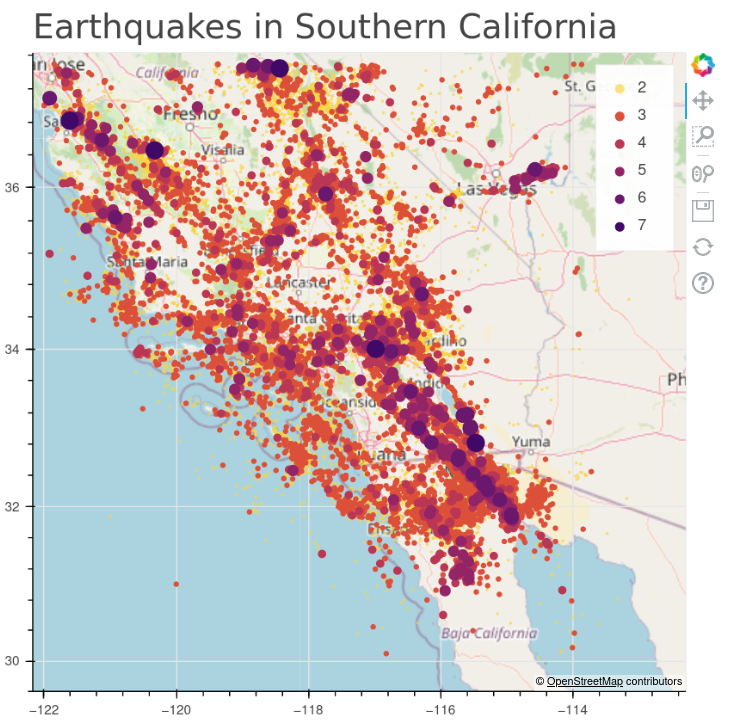

In [53]:
Image('images/bokehplot.png')

In [12]:
hide_toggle(for_next=True)

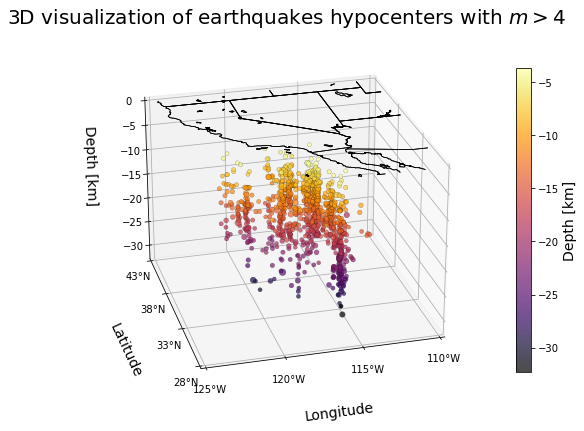

In [13]:
fig = plt.figure(figsize=(14,7))
ax = fig.gca(projection='3d')

extent = [-125,-110,28,43]

my_map = Basemap(
    projection='merc',
    resolution='i',
    fix_aspect=False, ax=ax,
    llcrnrlon=extent[0], llcrnrlat=extent[2],
    urcrnrlon=extent[1], urcrnrlat=extent[3])

ax.add_collection3d(my_map.drawcoastlines(linewidth=0.75))
ax.add_collection3d(my_map.drawcountries(linewidth=0.75))
ax.add_collection3d(my_map.drawstates(linewidth=0.75))
ax.view_init(azim = 255, elev = 25)

magn = 4
lon = df['longitude'][df['magnitude']>magn]
lat = df['latitude'][df['magnitude']>magn]
xm, ym = my_map(lon, lat)
zm = df['depth'][df['magnitude']>magn]/1000

xyz3D = ax.scatter3D(xm, ym, zm,
                   s=df['magnitude'][df['magnitude']>magn]**2,
                   c=df["depth"][df['magnitude']>magn]/1000,
                   cmap='inferno', edgecolors='k', linewidth=0.2, alpha=0.7)

cb = plt.colorbar(xyz3D, ax=ax, shrink=0.8)
cb.set_label(label='Depth [km]', fontsize=14)

ll = my_map(extent[0], extent[2])
ur = my_map(extent[1], extent[3])
meridians_t = np.arange(ll[0], 4*ur[0]/3, ur[0]/3)
meridians_l = ['125°W', '120°W', '115°W', '110°W']
ax.set_xticks(meridians_t)
ax.set_xticklabels(meridians_l)
parallels_t = np.arange(30*ll[1]/28, 45*ur[1]/43, ur[1]/3)
parallels_l = ['28°N', '33°N', '38°N', '43°N']
ax.set_yticks(parallels_t)
ax.set_yticklabels(parallels_l)

ax.set_xlabel(u'Longitude', fontsize=14, labelpad=20)
ax.set_ylabel(u'Latitude', fontsize=14, labelpad=20)
ax.set_zlabel(u'Depth [km]', fontsize=14, labelpad=20)
ax.set_zlim(np.min(zm), 0)
ax.set_title('3D visualization of earthquakes hypocenters with $m>{}$'.format(magn), fontsize=20)

plt.show()

## Time series

We represented some time series for several variables, such as the cumulative sum of the number of events, magnitude, and shperical coordinates of hypocenters (longitude, latitude, and depth).


In [14]:
hide_toggle(for_next=True)

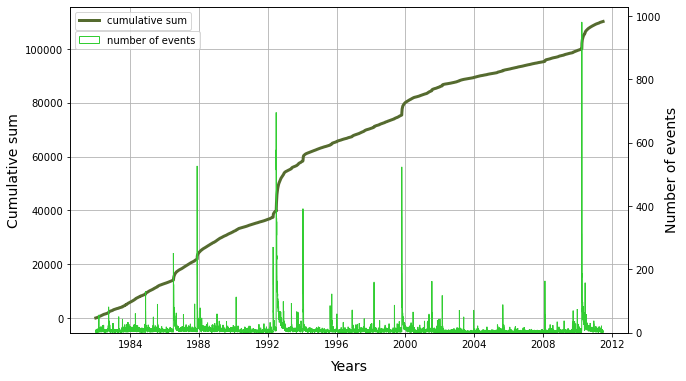

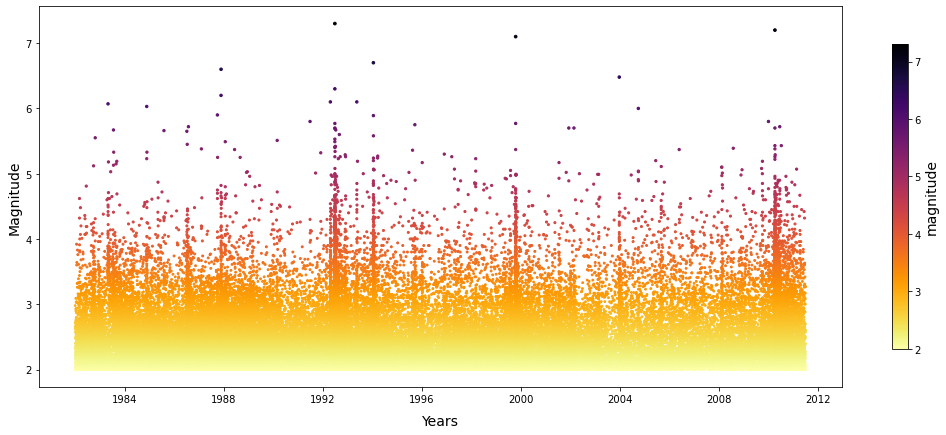

In [15]:
fig, (ax1) = plt.subplots(figsize=(10, 6), ncols=1)


ax1.plot(df['date'], df['index'], c='darkolivegreen', lw=3, label='cumulative sum')
ax1.set_xlabel('Years', labelpad=10, fontsize=14)
ax1.set_ylabel('Cumulative sum', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True)

#valutare se mettere o no
ax3 = ax1.twinx()
ax3_color = 'orange'
ax3.set_ylabel('Number of events',  size=14)
ax3.hist(df['date'], histtype='step', bins=29*365, color='limegreen', label='number of events'); 
ax3.tick_params(axis='y')
ax3.legend(loc='upper left',bbox_to_anchor=(0., 0.2, 0.6, 0.74))

fig, (ax2) = plt.subplots(figsize=(18, 7), ncols=1)

m_ts = ax2.scatter(df['date'], df['magnitude'], s=df['magnitude'], c=df['magnitude'], cmap='inferno_r')
ax2.set_xlabel('Years', labelpad=10, fontsize=14)
ax2.set_ylabel('Magnitude', fontsize=14)
cb = plt.colorbar(m_ts, ax=ax2, shrink=0.8)
cb.set_label(label='magnitude', fontsize=14)


plt.show()

In [16]:
hide_toggle(for_next=True)

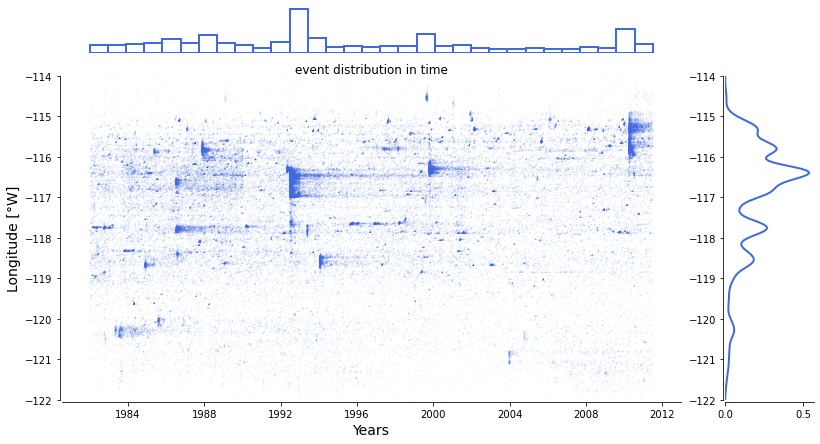

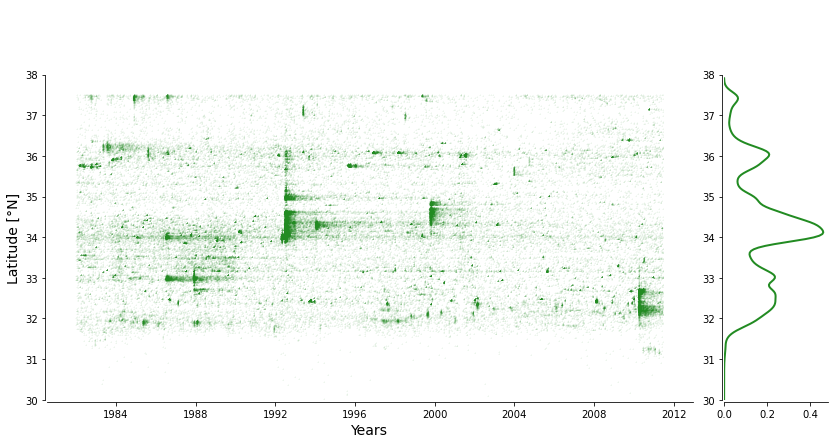

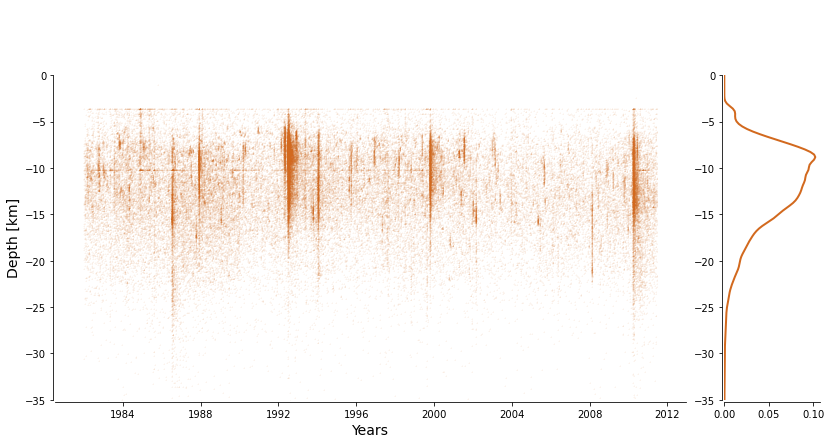

In [17]:
i=2
t = df['date'][df['magnitude']>i]
x = df['longitude'][df['magnitude']>i]
y = df['latitude'][df['magnitude']>i]
z = df['depth'][df['magnitude']>i]/1000


xt = sns.JointGrid(ylim=(-122,-114), space=0.5)
sns.scatterplot(x=t, y=x, s=1, marker='+', color='royalblue', ax=xt.ax_joint)
sns.histplot(x=t, fill=False, linewidth=2, bins=31, color='royalblue', ax=xt.ax_marg_x)
sns.kdeplot(y=x, linewidth=2, color='royalblue', ax=xt.ax_marg_y)
sns.despine(offset=2)
xt.ax_marg_x.set_axis_off()
xt.fig.set_figwidth(12)
xt.ax_joint.set_title('event distribution in time',pad=-5)
xt.set_axis_labels('Years', 'Longitude [°W]', fontsize=14)

yt = sns.JointGrid(ylim=(30,38), space=0.3)
sns.scatterplot(x=t, y=y, s=1, marker='+', color='forestgreen', ax=yt.ax_joint)
sns.kdeplot(y=y, linewidth=2, color='forestgreen', ax=yt.ax_marg_y)
sns.despine(offset=2)
yt.ax_marg_x.set_axis_off()
yt.fig.set_figwidth(12)
yt.set_axis_labels('Years', 'Latitude [°N]', fontsize=14)

zt = sns.JointGrid(ylim=(-35,0), space=0.4)
sns.scatterplot(x=t, y=z, s=1, marker='+', color='chocolate', ax=zt.ax_joint)
sns.kdeplot(y=z, linewidth=2, color='chocolate', ax=zt.ax_marg_y)
sns.despine(offset=2)
zt.ax_marg_x.set_axis_off()
zt.fig.set_figwidth(12)
zt.set_axis_labels('Years', 'Depth [km]', fontsize=14)

sns.reset_defaults()
plt.show()

As can be seen from the longitude and latitude plots, when there is high seismic activity, it appears to be spatially localized and with a protracted event density over time. In contrast, the same behavior does not appear in the depth time series.

## Gutenberg–Richter law
The Gutenberg–Richter law describes the number of earthquakes - in any given region and time period - with magnitude $M$ greater than $m$:

$\log_{10} N(M\geq m) = a + b\cdot m$

or

$N(M\geq m) = 10^a 10^{b\cdot m}$

For $m = 0$ we find:

$N(M\geq m=0) = 10^a = N_{tot}$

The parameter $b$  is commonly close to $-1$.

In [18]:
hide_toggle(for_next=True)

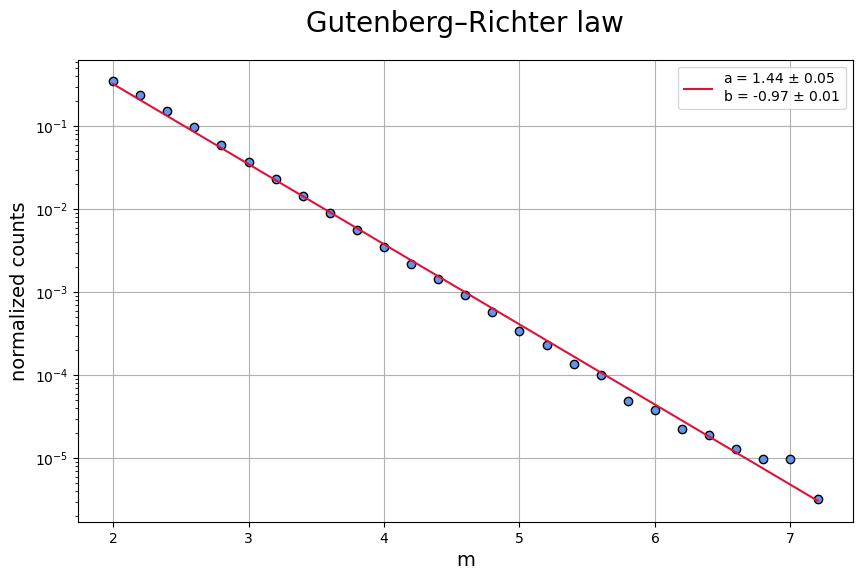

In [19]:
magnitudes = np.arange(2,8,0.2)
counts = np.zeros(magnitudes.shape[0])

# compute the number of events with magnitude M >= m
i = 0
for m in magnitudes:
    counts[i] = df[df['magnitude'] >= m]['magnitude'].count()
    i += 1

# normalize counts
norm = np.sum(counts)   
counts_n = counts/norm

# filter by removing empty bins for the log plot
counts_n_f = counts_n[counts_n!=0]
magnitudes_f = magnitudes[counts_n!=0]

# compute linear regression
reg = stats.linregress(magnitudes_f, np.log10(counts_n_f))

fig, ax = plt.subplots(figsize=(10,6))

# plot histogram
ax.plot(magnitudes_f, counts_n_f, 'o', mfc='cornflowerblue', mec='black')
# plot linear regression
label = r'a = {:.2f} $\pm$ {:.2f}'.format(reg.intercept, reg.intercept_stderr) + '\n' + r'b = {:.2f} $\pm$ {:.2f}'.format(reg.slope, reg.stderr)
plt.plot(magnitudes_f, 10**(reg.intercept + reg.slope*magnitudes_f), 'crimson', label=label)
ax.set_yscale('log')
ax.set_xlabel('m', fontsize=14)
ax.set_ylabel(r'normalized counts', fontsize=14)
ax.set_title('Gutenberg–Richter law', fontsize=20, pad=20)
plt.legend()
plt.grid()
plt.show()

The slope b of the linear regression is close to 1, meaning that for a given frequency of events with magnitude $m$ or greater there will be 10 times as many events with magnitude $m-1$ or greater.

## Waiting time distribution $P_m(\tau)$
We have computed the distribution of waiting times $\tau$ (defined as the time interval between one event and the next one) for events of magnitude m or above which is expected to have a power-law decay:

$P_m(\tau) = k\cdot\tau^{-p}$ , with $p > 0$

Therefore we have chosen bins of exponentially increasing width, the so-called logarithmic binning, and performed a weighted linear regression in a log-log scale after having properly normalized the data:

$\log_{10}(P_m(\tau)) = \log_{10}(k) -p \log_{10}(\tau)$ 

For the generic form of a linear regression function such as $y = a + b \cdot x$ we then have the following correspondence:

$a = \log_{10}(k)$ , namely $k = 10^a$

$b = -p$

In [20]:
hide_toggle(for_next=True)

In [21]:
# generic form of linear regression function
def f(x, a, b):
    return a + b*x



The problem is that $P_m(\tau)$ does not exhibit a power law behavior for all waiting times, which range from a few seconds to years. Therefore we had to implement an algorithm to select only the bins for the linear regression that are likely to be in the power law regime and discard the other ones. In particular:

* In the left hand side we have considered only bins with waiting times greater than a certain threshold, fixed at 60s, in order to avoid the flat initial behavior of the distribution. This has been done because for very low waiting times the earthquakes overlap and there is difficulty in separating the events.

* In the right hand side we have rejected the bins belong to the rapidly decreasing part of the distribution. In order to do that we have built an algorithm that iteratively discards a bin starting from the last one until the sample correlation coefficient $\rho$ stops improving. In this way we are jointly maximizing the number of bins considered for the linear regression and the value of $\rho$.

In [22]:
hide_toggle(for_next=True)

In [23]:
# algorithm to select the bins fot the linear regression given the threshold t_in
def rejecting_algorithm(bin_centers_f, counts_n_f, t_in): 

    start = np.argmin(np.abs(bin_centers_f - t_in))
    end = -1
    r_best = 0
    reject = True

    while (reject): 
        x = np.log10(bin_centers_f[start:end])
        y = np.log10(counts_n_f[start:end])
        r = np.abs(np.corrcoef([x,y])[0,1])
        if r > r_best:
            r_best = r
            end -= 1
        else:
            reject = False

    return start, end

The errors used by weighted linear regression come from a propagation process. First, the data represent counts, so we assigned each bin the Poisson uncertainty, defined as:

$\sigma_{N_i} = \sqrt{N_i}$ , where $N_i$ is the number of counts for each bin

Then, because we normalized the counts and evaluated the logarithm to show them in a log-log scale, we had to propagate the uncertainties:

$\tilde{\sigma}_{N_i} = \sigma_{N_i}/(N_i \cdot \log(10))$

In [24]:
hide_toggle(for_next=True)

In [25]:
# function to propagate the Poisson uncertainty of the counts
def counts_uncertainty(counts, bin_widths, norm):

    # normalize counts
    counts_n = counts/(bin_widths*norm)
    # poisson uncertainty for counts
    sigma_counts = np.sqrt(counts[counts_n!=0]) 
    # propagation of the poisson uncertainty for counts 
    sigma_counts_n_f_log = (1/(counts[counts_n!=0]*np.log(10)))*sigma_counts

    return sigma_counts_n_f_log

We used the $\chi^2$ goodness of fit test to determine if the data are consistent with the assumed linear dependence. If the p-value is $< 0.05$, the fit is considered unsatisfactory.

In [26]:
hide_toggle(for_next=True)

In [27]:
# chi2 goodness of fit test
def chi2_test(bin_centers_f, counts_n_f, sigma_counts_n_f_log, start, end, par):

    x = np.log10(bin_centers_f[start:end])
    y = np.log10(counts_n_f[start:end])
    sigma_y = sigma_counts_n_f_log[start:end]

    ndof = len(x) - 1
    chi2 = np.sum(((y - (par[0]+par[1]*x))**2)/sigma_y)
    pvalue = 1 - stats.chi2.cdf(chi2, ndof)

    print('ndof = {:.2f}, chi2 = {:.2f}, pvalue = {:.4f}'.format(ndof, chi2, pvalue))

    return pvalue

In [28]:
hide_toggle(for_next=True)

magnitude m = 2.00
ndof = 14.00, chi2 = 1.96, pvalue = 0.9999
magnitude m = 3.00
ndof = 22.00, chi2 = 1.99, pvalue = 1.0000
magnitude m = 4.00
ndof = 26.00, chi2 = 2.37, pvalue = 1.0000
magnitude m = 5.00
ndof = 27.00, chi2 = 4.40, pvalue = 1.0000


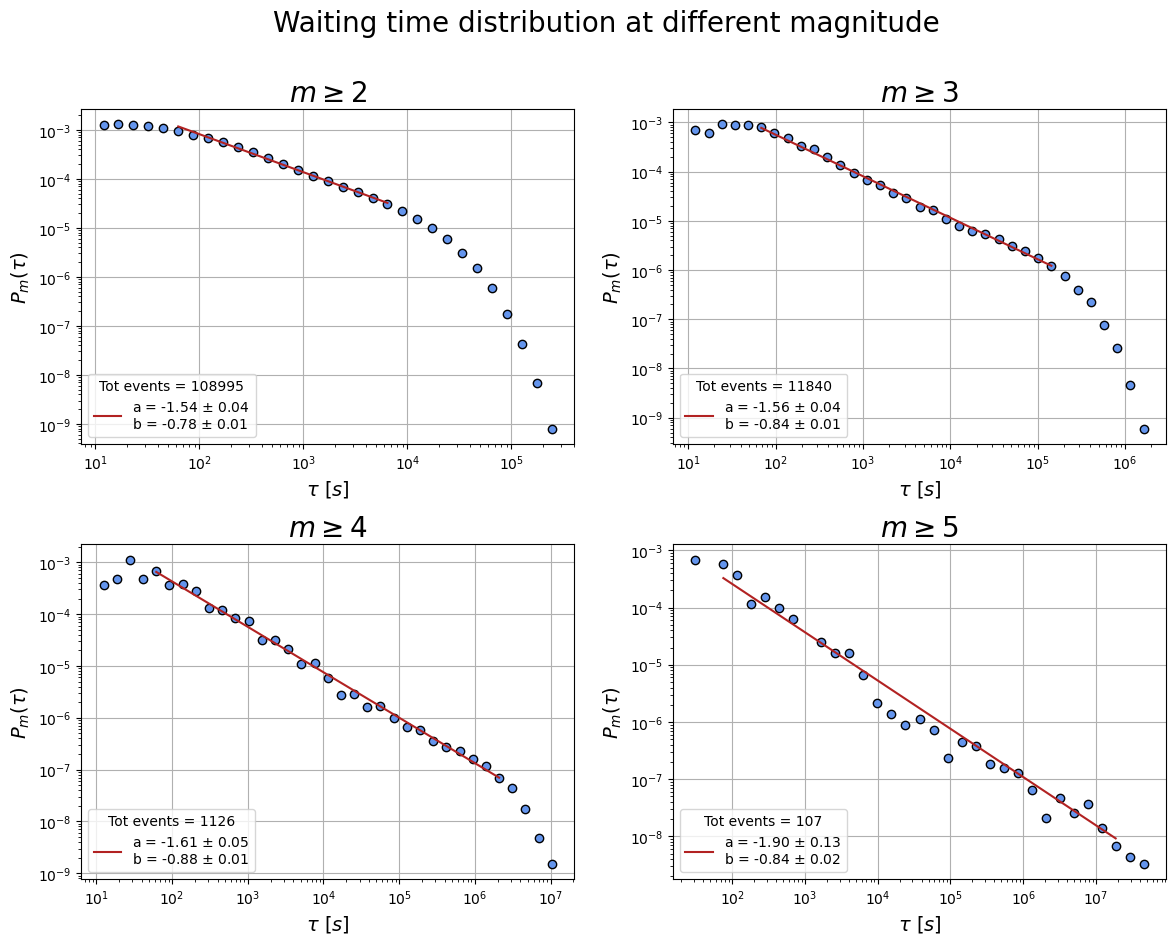

In [29]:
dfm = df.copy()

for i in range(2,7):
    dfm['w_Time_m'+str(i)] = dfm[dfm['magnitude']>=i]['time'].diff()
    dfm['diff_x_m'+str(i)] = dfm[dfm['magnitude']>=i]['X'].diff()
    dfm['diff_y_m'+str(i)] = dfm[dfm['magnitude']>=i]['Y'].diff()
    dfm['diff_z_m'+str(i)] = dfm[dfm['magnitude']>=i]['Z'].diff()
    dfm['R_m'+str(i)] = np.sqrt((dfm['diff_x_m'+str(i)])**2
                               +(dfm['diff_y_m'+str(i)])**2
                               +(dfm['diff_z_m'+str(i)])**2)

fig, ax = plt.subplots(2,2, figsize=(14, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.2)
ax = ax.ravel()
fig.suptitle("Waiting time distribution at different magnitude", fontsize=20)

s = 10  # minimum waiting time to be shown
b = 10  # base of logarithmic bins
n = 35  # number of bins

for i in range(2,6):
    
    # logarithmic bins
    logbin = np.logspace(start=math.log(s,b),
                       stop=math.log(dfm['w_Time_m'+str(i)].max(),b),
                       base=b, num=n+1)
    
    # histogram
    counts, bin_edges = np.histogram(dfm['w_Time_m'+str(i)], bins=logbin)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    
    # normalize counts
    norm = np.sum(counts)   
    counts_n = counts/(bin_widths*norm)

    # filter by removing empty bins for the log-log plot
    counts_n_f = counts_n[counts_n!=0]
    bin_centers_f = bin_centers[counts_n!=0]

    # select bins 
    start, end = rejecting_algorithm(bin_centers_f, counts_n_f, 60)

    # counts uncertainty ready for the log-log plot
    sigma_counts_n_f_log = counts_uncertainty(counts, bin_widths, norm)

    # compute linear regression
    x = np.log10(bin_centers_f[start:end])
    y = np.log10(counts_n_f[start:end])
    sigma_y = sigma_counts_n_f_log[start:end]
    par, cov = optimize.curve_fit(f, x, y, sigma=sigma_y)

    # chi2 goodness of fit test 
    print('magnitude m = {:.2f}'.format(i))
    pvalue = chi2_test(bin_centers_f, counts_n_f, sigma_counts_n_f_log, start, end, par)

    # plot histogram
    ax[i-2].plot(bin_centers_f, counts_n_f, 'o', mfc='cornflowerblue', mec='black')
    # plot linear regression
    label = r'a = {:.2f} $\pm$ {:.2f}'.format(par[0], np.sqrt(cov[0,0])) + '\n' + r'b = {:.2f} $\pm$ {:.2f}'.format(par[1], np.sqrt(cov[1,1]))
    ax[i-2].plot(bin_centers_f[start:end], (10**par[0])*(bin_centers_f[start:end]**par[1]), 'firebrick', label=label)
    ax[i-2].set_title('$m \geq {}$'.format(i,R), fontsize=20)
    ax[i-2].set_xlabel(r'$\tau \ [s]$', fontsize=14)
    ax[i-2].set_ylabel(r'$P_{m}(\tau)$', fontsize=14)
    ax[i-2].set_xscale('log')
    ax[i-2].set_yscale('log')
    ax[i-2].legend(title='Tot events = {}'.format(norm), loc='lower left')
    ax[i-2].grid()


plt.show()


Then we analyzed the maximum waiting time $\tau_{max}$ selected by the algorithm at various $m$ to see if there is a dependency between the two variables.

In [30]:
hide_toggle(for_next=True)

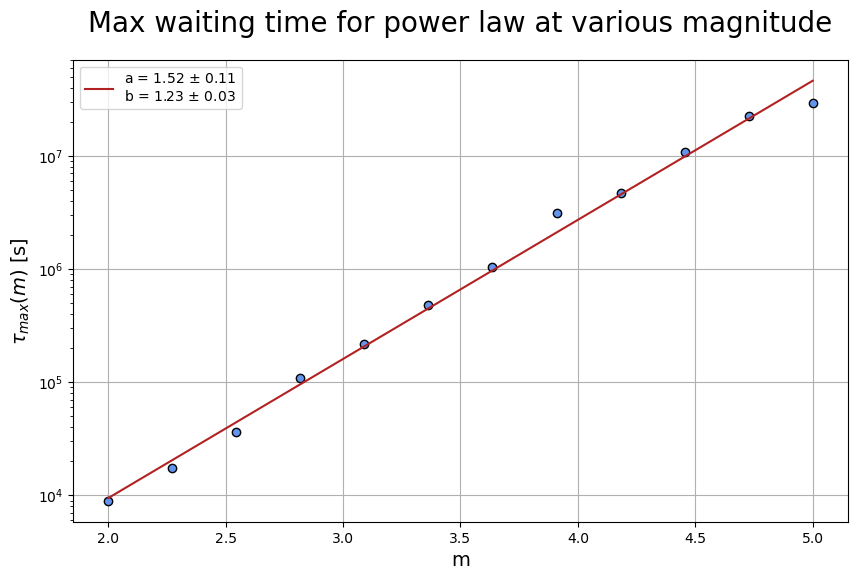

In [31]:
df_wt_sx = df.copy()

list_m = np.linspace(2,5,12)
list_tau_max = []

for i in list_m:
    df_wt_sx['w_Time_m'+str(i)] = df_wt_sx[df_wt_sx['magnitude']>=i]['time'].diff()

for i in list_m:

    # logarithmic bins
    logbin = np.logspace(start=math.log(s,b),
                         stop=math.log(df_wt_sx['w_Time_m'+str(i)].max(),b),
                         base=b, num=n+1)
    
    # histogram
    counts,bin_edges = np.histogram(df_wt_sx['w_Time_m'+str(i)], bins=logbin)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    
    # normalize counts
    norm = np.sum(counts)   
    counts_n = counts/(bin_widths*norm)   

    # filter by removing empty bins for the log-log plot
    counts_n_f = counts_n[counts_n!=0]
    bin_centers_f = bin_centers[counts_n!=0]

    # select bins
    start, end = rejecting_algorithm(bin_centers_f, counts_n_f, 60)

    list_tau_max.append(bin_centers_f[end])

# compute linear regression
par, cov = optimize.curve_fit(f, list_m, np.log10(list_tau_max))

a_tau_max, b_tau_max = par[0], par[1]

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(list_m, list_tau_max, 'o', mfc='cornflowerblue', mec='black')
label = r'a = {:.2f} $\pm$ {:.2f}'.format(par[0], np.sqrt(cov[0,0])) + '\n' + r'b = {:.2f} $\pm$ {:.2f}'.format(par[1], np.sqrt(cov[1,1]))   
ax1.plot(list_m, 10**(f(list_m, a_tau_max, b_tau_max)), 'firebrick', label=label)
ax1.set_ylabel(r'$\tau_{max}(m)$ [s]', fontsize=14)
ax1.set_xlabel('m', fontsize=14)
ax1.set_yscale('log')
ax1.set_title('Max waiting time for power law at various magnitude', fontsize=20, pad=20)
ax1.legend(loc='upper left')
ax1.grid()

plt.show()


 As can be seen, there is a linear dependence between the logarithm of the maximum waiting time $\tau_{max}(m)$ and the magnitude $m$, which means that the range of the power-law regime increases as the magnitude cut-off increases. This dependence suggests that there might be a suitable rescaling that collapses the distributions for various $m$. We have that:

$\log_{10}(\tau_{max}(m)) = a + b \cdot m$

where the parameters $a$ and $b$ are obtained through a linear regression.

Making the exponential:

$\tau_{max}(m) = 10^{a}10^{b \cdot m}$

We said that the power law regime holds when $\tau < \tau_{max}(m)$, which can be rewritten as:

$\tau/\tau_{max}(m) < 1$

or explicitly

$\tau \cdot 10^{-a}10^{-b \cdot m} < 1$

Therefore, we plotted several distributions of the waiting time for different $m$ as functions of $x=\tau/\tau_{max}(m)$ since we expect all curves to stop following a power law regime at x = 1. Moreover, to make the scaling picture look better we have divided $P_{m}(\tau)$ by $k \cdot \tau^{-p}$ since we expect this ratio to be equal to $1$ in the power-law regime. In fact, we got that:

$P_{m}(\tau) = k \cdot \tau^{-p}$

where k and p are obtained by a weigthed linear regression on a log-log scale using logarithmic binning, ranging from the threshold to $\tau_{max}(m)$. Thus:

$P_{m}(\tau) \cdot k^{-1} \cdot \tau^{p} = 1$ 

In [32]:
hide_toggle(for_next=True)

In [ ]:
######## UNCOMMENT BELOW TO USE INTERACTIVE BOKEH PLOT #######


"""    df_scaling = df.copy()

    list_m = np.linspace(2,4,5)

    for i in list_m:
        df_scaling['w_Time_m'+str(i)] = df_scaling[df_scaling['magnitude']>=i]['time'].diff()
        df_scaling['diff_x_m'+str(i)] = df_scaling[df_scaling['magnitude']>=i]['X'].diff()
        df_scaling['diff_y_m'+str(i)] = df_scaling[df_scaling['magnitude']>=i]['Y'].diff()
        df_scaling['diff_z_m'+str(i)] = df_scaling[df_scaling['magnitude']>=i]['Z'].diff()
        df_scaling['R_m'+str(i)] = np.sqrt((df_scaling['diff_x_m'+str(i)])**2
                                   +(df_scaling['diff_y_m'+str(i)])**2
                                   +(df_scaling['diff_z_m'+str(i)])**2)

    s_scaling = 60 # minimum waiting time to be shown

    p = figure(width=800, height=600, x_axis_type="log", y_axis_type="log")
    p.title.text = 'Scaling picture for different m'
    p.xaxis.axis_label = r'$$\frac{\tau}{\tau_{max}(m)}$$'
    p.yaxis.axis_label = r"$$\frac{P_{m}(\tau)}{k\cdot\tau^{-p}}$$"
    p.title.text_font_size = "28px"
    p.title.text_font = 'sans-serif'
    p.title.text_font_style = 'normal'


    colors =  np.array([Set1[6][i] for i in range(len(list_m))])
    l=0

    for i in list_m:

        # theorical maximum waiting time 
        tau_max_theo = 10**(f(i, a_tau_max, b_tau_max))

        # logarithmic bins
        logbin = np.logspace(start=math.log(s_scaling,b),
                           stop=math.log(df_scaling['w_Time_m'+str(i)].max(),b),
                           base=b, num=n+1)

        # histogram
        counts, bin_edges = np.histogram(df_scaling['w_Time_m'+str(i)], bins=logbin)
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
        bin_widths = bin_edges[1:] - bin_edges[:-1]

        # normalize counts
        norm = np.sum(counts)       
        counts_n = counts/(bin_widths*norm)

        # filter by removing empty bins for the log-log plot
        counts_n_f = counts_n[counts_n!=0]
        bin_centers_f = bin_centers[counts_n!=0]

        # counts uncertainty ready for the log-log plot
        sigma_counts_n_f_log = counts_uncertainty(counts, bin_widths, norm)

        # select waiting time ranging from the threshold t_in to the theorical maximum waiting time
        t_in = 60
        start = np.argmin(np.abs(bin_centers_f - t_in))
        end = np.argmin(np.abs(bin_centers_f - tau_max_theo))

        # compute linear regression
        x = np.log10(bin_centers_f[start:end])
        y = np.log10(counts_n_f[start:end])
        sigma_y = sigma_counts_n_f_log[start:end]
        par, cov = optimize.curve_fit(f, x, y, sigma=sigma_y)

        # scaling of x and y
        x_scaled = bin_centers_f/tau_max_theo
        y_scaled = counts_n_f/(bin_centers_f**par[1]*10**par[0])

        p.line(x_scaled, y_scaled, line_width=2, line_dash='dashed', color=colors[l], legend_label='m = {}'.format(i))
        p.circle(x_scaled, y_scaled, size=6, color=colors[l], legend_label='m = {}'.format(i))

        l+=1


    p.legend.location = "bottom_left"
    p.legend.click_policy="hide"


    show(p)"""


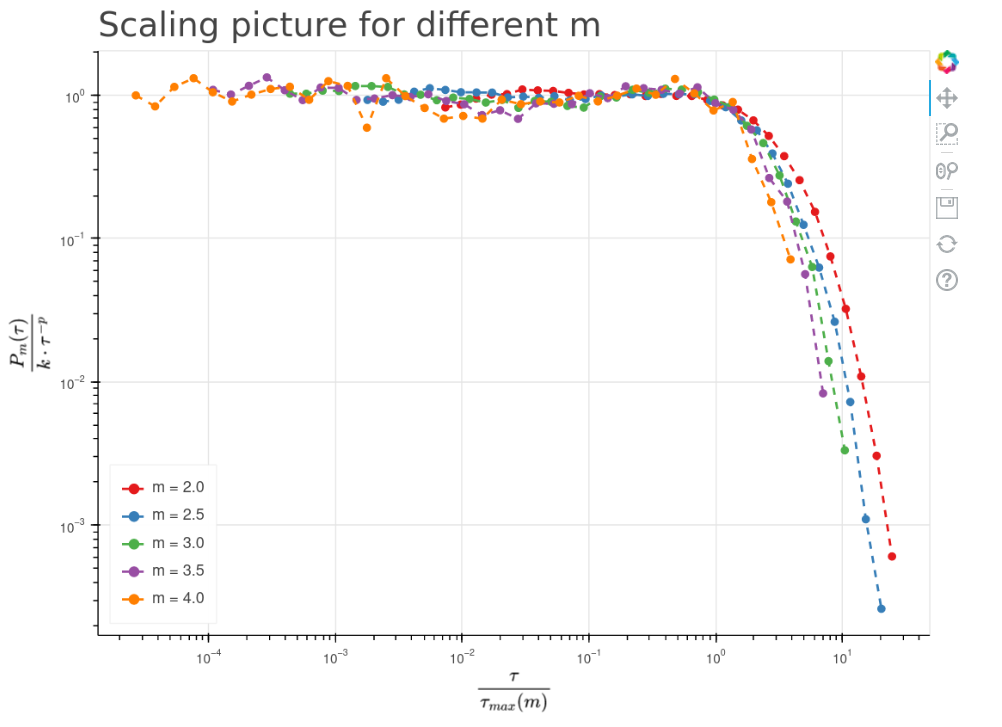

In [52]:
Image('images/bokehscale_m.png')

## Distance distribution $P_m(r)$
We have computed the distribution of the distance $r$ between one event and the next one, given events of magnitude $m$ or above. We have applied the same arguments already described for the distribution of the waiting time $\tau$. Namely, we have considered a power-law decay:

$P_m(r) = k \cdot r^{-p}$ , with $p > 0$

We have choosen logarithmic binning and performed a weighted linear regression in a log-log scale after having properly normalized the data:

$\log_{10}(P_m(r)) = \log_{10}(k) -p \log_{10}(r)$ 

We have used the same algorithm to select only the bins for the linear regression that are likely to be in the power law regime, with the threshold fixed at $1$ km.

In [34]:
hide_toggle(for_next=True)

magnitude m = 2.00
ndof = 27.00, chi2 = 15.98, pvalue = 0.9534
magnitude m = 3.00
ndof = 28.00, chi2 = 9.08, pvalue = 0.9997
magnitude m = 4.00
ndof = 28.00, chi2 = 6.19, pvalue = 1.0000
magnitude m = 5.00
ndof = 27.00, chi2 = 4.54, pvalue = 1.0000


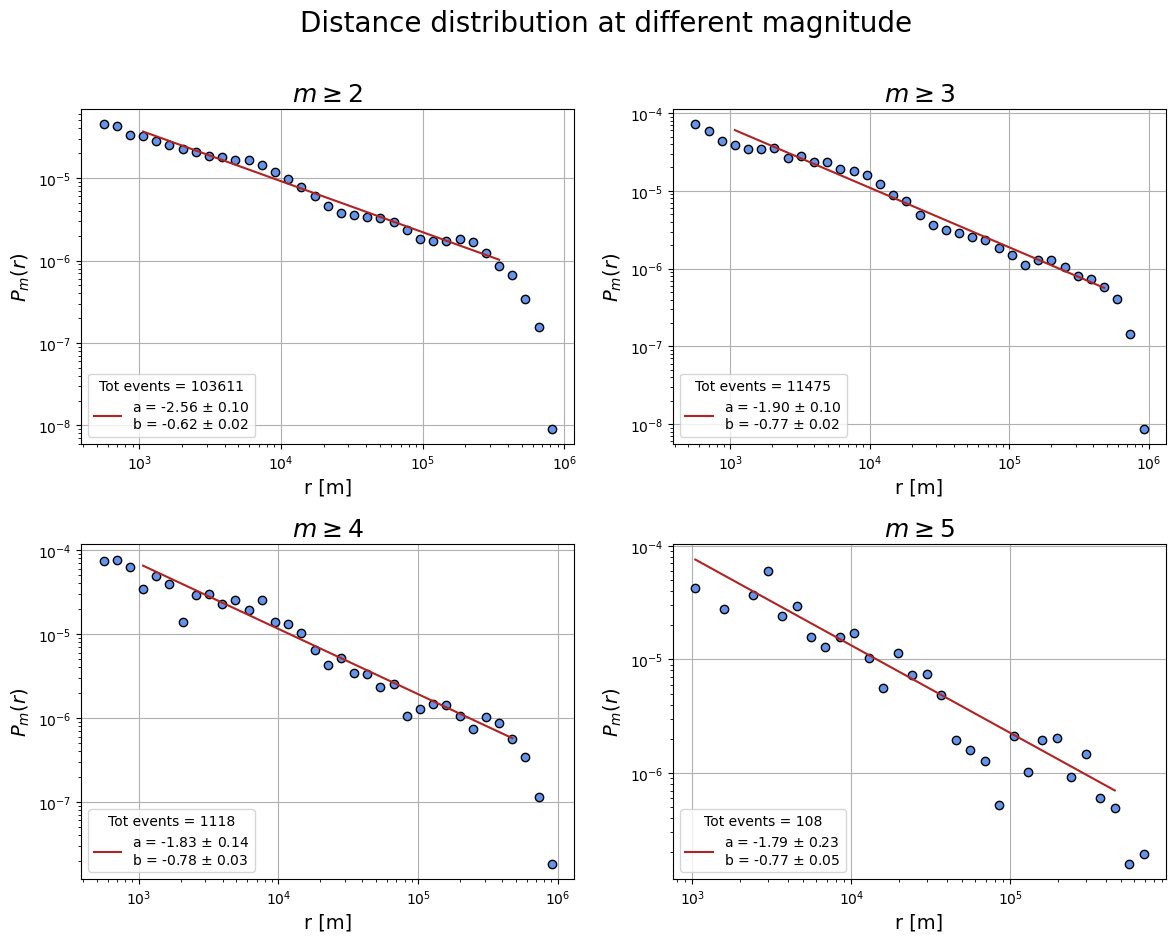

In [35]:
fig, ax = plt.subplots(2,2, figsize=(14, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.2)
ax = ax.ravel()
fig.suptitle("Distance distribution at different magnitude", fontsize=20)

r_min = 500 # minimum distance to be shown

for i in range(2,6):
    
    # logarithmic bins
    logbin = np.logspace(start=math.log(r_min,b),
                       stop=math.log(dfm['R_m'+str(i)].max(),b),
                       base=b, num=n+1)
    
    # histogram
    counts, bin_edges = np.histogram(dfm['R_m'+str(i)], bins=logbin)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    
    # normalize counts
    norm = np.sum(counts)   
    counts_n = counts/(bin_widths*norm)

    # filter by removing empty bins for the log-log plot
    counts_n_f = counts_n[counts_n!=0]
    bin_centers_f = bin_centers[counts_n!=0]

    # counts uncertainty ready for the log-log plot
    sigma_counts_n_f_log = counts_uncertainty(counts, bin_widths, norm)

    # select bins 
    start, end = rejecting_algorithm(bin_centers_f, counts_n_f, 1000)

    # compute linear regression
    x = np.log10(bin_centers_f[start:end])
    y = np.log10(counts_n_f[start:end])
    sigma_y = sigma_counts_n_f_log[start:end]
    par, cov = optimize.curve_fit(f, x, y, sigma=sigma_y)

    # chi2 goodness of fit test 
    print('magnitude m = {:.2f}'.format(i))
    pvalue = chi2_test(bin_centers_f, counts_n_f, sigma_counts_n_f_log, start, end, par)

    # plot histogram
    ax[i-2].plot(bin_centers_f, counts_n_f, 'o', mfc='cornflowerblue', mec='black')
    # plot linear regression
    label = r'a = {:.2f} $\pm$ {:.2f}'.format(par[0], np.sqrt(cov[0,0])) + '\n' + r'b = {:.2f} $\pm$ {:.2f}'.format(par[1], np.sqrt(cov[1,1]))
    ax[i-2].plot(bin_centers_f[start:end], (10**par[0])*(bin_centers_f[start:end]**par[1]), 'firebrick', label=label)
    ax[i-2].set_title('$m \geq {}$'.format(i,R), fontsize=18)
    ax[i-2].set_xlabel('r [m]', fontsize=14)
    ax[i-2].set_ylabel('$P_{m}(r)$', fontsize=14)
    ax[i-2].set_xscale('log')
    ax[i-2].set_yscale('log')
    ax[i-2].legend(title='Tot events = {}'.format(norm), loc='lower left')
    ax[i-2].grid()

plt.show()


Also in this case we have analyzed the maximum distance $r_{max}$ selected by the algorithm at various $m$ to see if there is a dependency between the two variables.

In [36]:
hide_toggle(for_next=True)

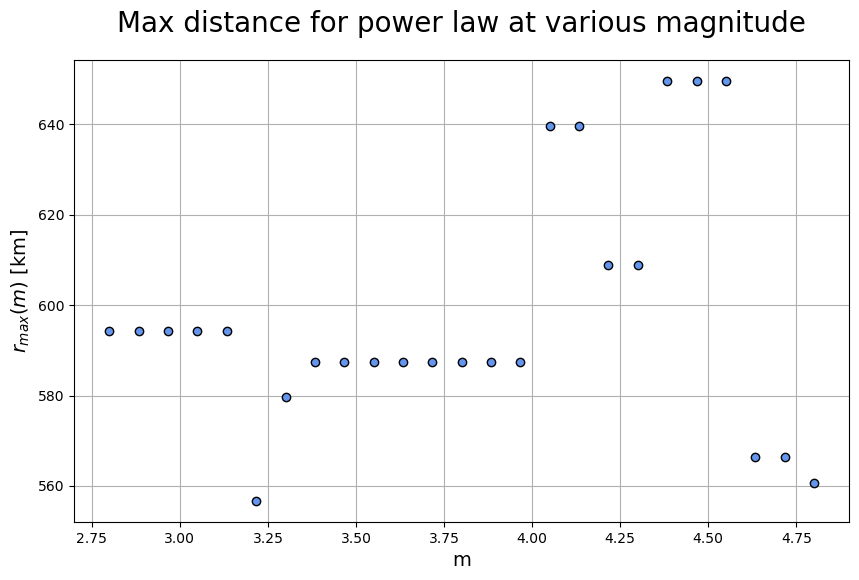

In [37]:
df_d = df.copy()

list_m = np.linspace(2.8,4.8,25)
list_d_max = []

for i in list_m:
    df_d['diff_x_m'+str(i)]=df_d[df_d['magnitude']>=i]['X'].diff()
    df_d['diff_y_m'+str(i)]=df_d[df_d['magnitude']>=i]['Y'].diff()
    df_d['diff_z_m'+str(i)]=df_d[df_d['magnitude']>=i]['Z'].diff()
    df_d['R_m'+str(i)]=np.sqrt((df_d['diff_x_m'+str(i)])**2
                               +(df_d['diff_y_m'+str(i)])**2
                               +(df_d['diff_z_m'+str(i)])**2)

for i in list_m:

    # logarithmic bins
    logbin = np.logspace(start=math.log(r_min,b),
                         stop=math.log(df_d['R_m'+str(i)].max(),b),
                         base=b, num=n+1)
    
    # histogram
    counts,bin_edges = np.histogram(df_d['R_m'+str(i)], bins=logbin)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    
    # normalize counts
    norm = np.sum(counts)   
    counts_n = counts/(bin_widths*norm)   

    # filter by removing empty bins for the log-log plot
    counts_n_f = counts_n[counts_n!=0]
    bin_centers_f = bin_centers[counts_n!=0]

    # select bins
    start, end = rejecting_algorithm(bin_centers_f, counts_n_f, 1000)

    list_d_max.append(bin_centers_f[end])

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(list_m, np.array(list_d_max)/1000, 'o', mfc='cornflowerblue', mec='black')
ax1.set_ylabel('$r_{max}(m)$ [km]', fontsize=14)
ax1.set_xlabel('m', fontsize=14)
ax1.set_title('Max distance for power law at various magnitude', fontsize=20, pad=20)
ax1.grid()

plt.show()


As can be seen, there is no clear dependence between $r_{max}$ and $m$. Therefore, we are unable to find a rescaling for the distance distribution $P_m(r)$.

## Waiting time distribution with distance cut-off $P_{m,r}(\tau)$

We again analyzed the distribution of waiting times $\tau$ by skipping those related to event pairs further than the cut-off $r$.

In [39]:
hide_toggle(for_next=True)

magnitude = 2
ndof = 16.00, chi2 = 5.06, pvalue = 0.9954
magnitude = 3
ndof = 19.00, chi2 = 1.21, pvalue = 1.0000


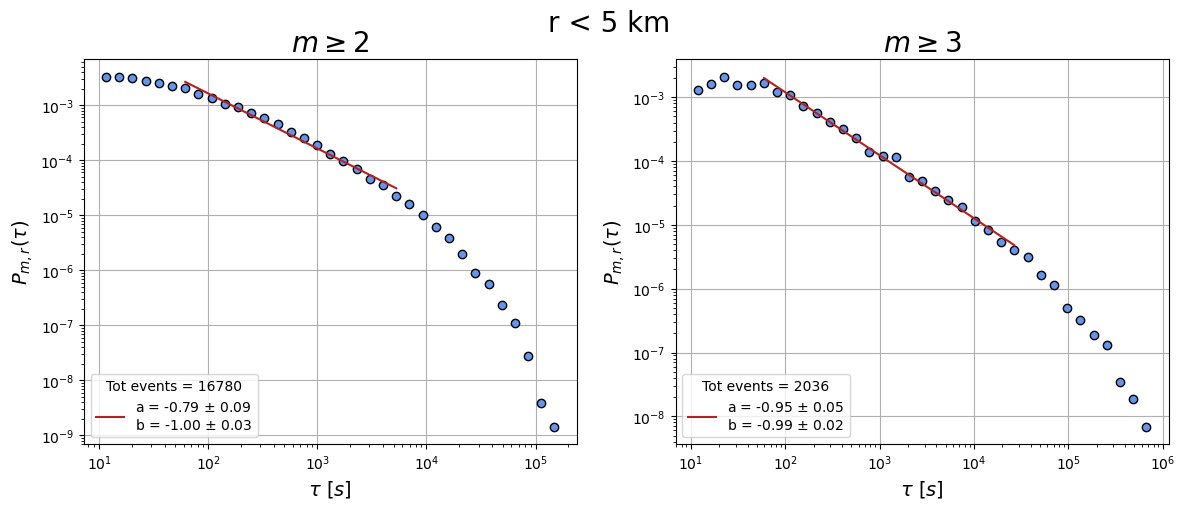

magnitude = 2
ndof = 17.00, chi2 = 9.31, pvalue = 0.9299
magnitude = 3
ndof = 20.00, chi2 = 1.96, pvalue = 1.0000


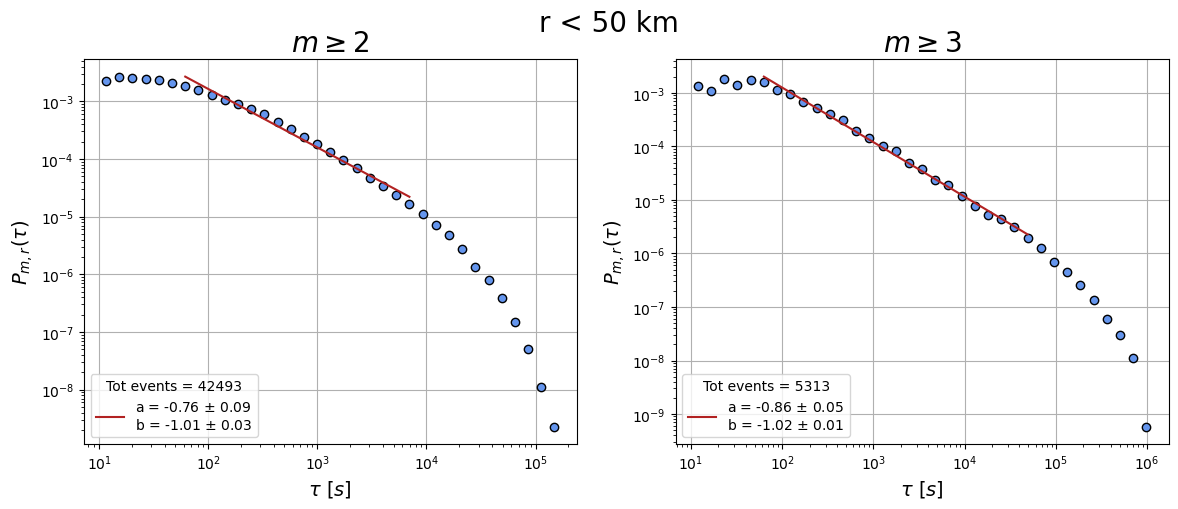

magnitude = 2
ndof = 14.00, chi2 = 2.24, pvalue = 0.9998
magnitude = 3
ndof = 22.00, chi2 = 1.82, pvalue = 1.0000


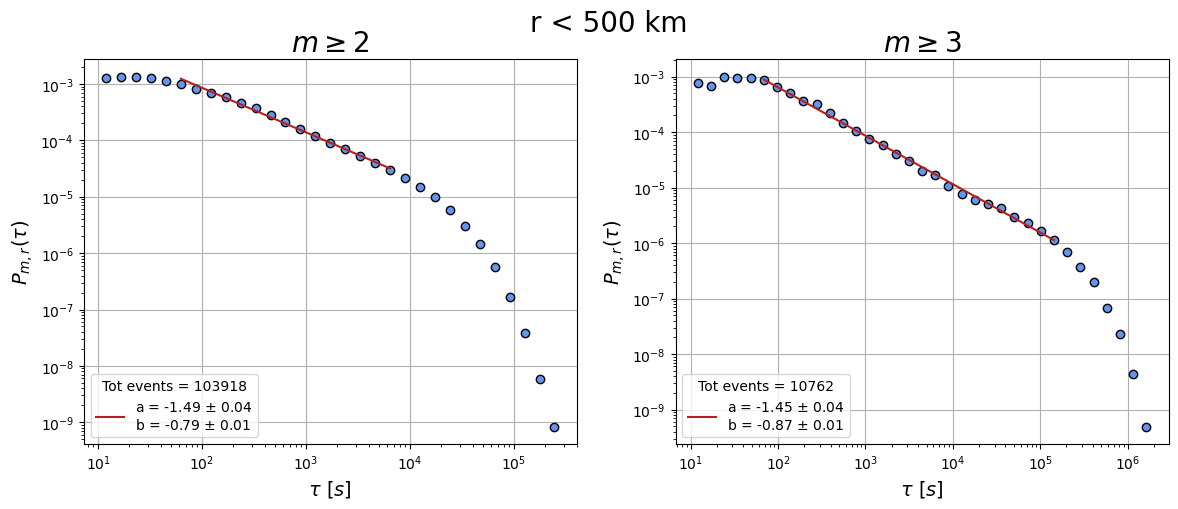

In [40]:
list_m = [2, 3]
list_r =  np.array([5e3, 5e4, 5e5])

for r in list_r:
    
    fig, ax = plt.subplots(1,2, figsize=(14, 5))
    fig.subplots_adjust(wspace=0.2)
    fig.suptitle('r < {:.0f} km'.format(r/1000), fontsize=20)
    
    for i in list_m:

        # logarithmic bins
        logbin = np.logspace(start=math.log(s,b),
                           stop=math.log(dfm[dfm['R_m'+str(i)]<r]['w_Time_m'+str(i)].max(),b),
                           base=b, num=n+1)

        # histogram
        counts, bin_edges = np.histogram(dfm[dfm['R_m'+str(i)]<r]['w_Time_m'+str(i)], bins=logbin)
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
        bin_widths = bin_edges[1:] - bin_edges[:-1]

        # normalize counts
        norm = np.sum(counts)   
        counts_n = counts/(bin_widths*norm)

        # filter by removing empty bins for the log-log plot
        counts_n_f = counts_n[counts_n!=0]
        bin_centers_f = bin_centers[counts_n!=0]

        # select bins 
        start, end = rejecting_algorithm(bin_centers_f, counts_n_f, 60)

        # counts uncertainty ready for the log-log plot
        sigma_counts_n_f_log = counts_uncertainty(counts, bin_widths, norm)

        # compute linear regression
        x = np.log10(bin_centers_f[start:end])
        y = np.log10(counts_n_f[start:end])
        sigma_y = sigma_counts_n_f_log[start:end]
        par, cov = optimize.curve_fit(f, x, y, sigma=sigma_y)

        # chi2 goodness of fit test
        print('magnitude =', i) 
        pvalue = chi2_test(bin_centers_f, counts_n_f, sigma_counts_n_f_log, start, end, par)

        # plot histogram
        ax[i-2].plot(bin_centers_f, counts_n_f, 'o', mfc='cornflowerblue', mec='black')
        # plot linear regression
        label = r'a = {:.2f} $\pm$ {:.2f}'.format(par[0], np.sqrt(cov[0,0])) + '\n' + r'b = {:.2f} $\pm$ {:.2f}'.format(par[1], np.sqrt(cov[1,1]))
        ax[i-2].plot(bin_centers_f[start:end], (10**par[0])*(bin_centers_f[start:end]**par[1]), 'firebrick', label=label)
        ax[i-2].set_title('$m \geq {}$'.format(i,R), fontsize=20)
        ax[i-2].set_xlabel(r'$\tau \ [s]$', fontsize=14)
        ax[i-2].set_ylabel(r'$P_{m,r}(\tau)$', fontsize=14)
        ax[i-2].set_xscale('log')
        ax[i-2].set_yscale('log')
        ax[i-2].legend(title='Tot events = {}'.format(norm), loc='lower left')
        ax[i-2].grid()

    plt.show()


We can observe that we still have power-law decay even with the introduction of the cut-off on the distance $r$.

Thus, we have analyzed the maximum waiting time $\tau_{max}$ selected by the algorithm at various $r$ for different fixed $m$ to see if there is a dependency between $\tau_{max}$ and $r$.

In [41]:
hide_toggle(for_next=True)

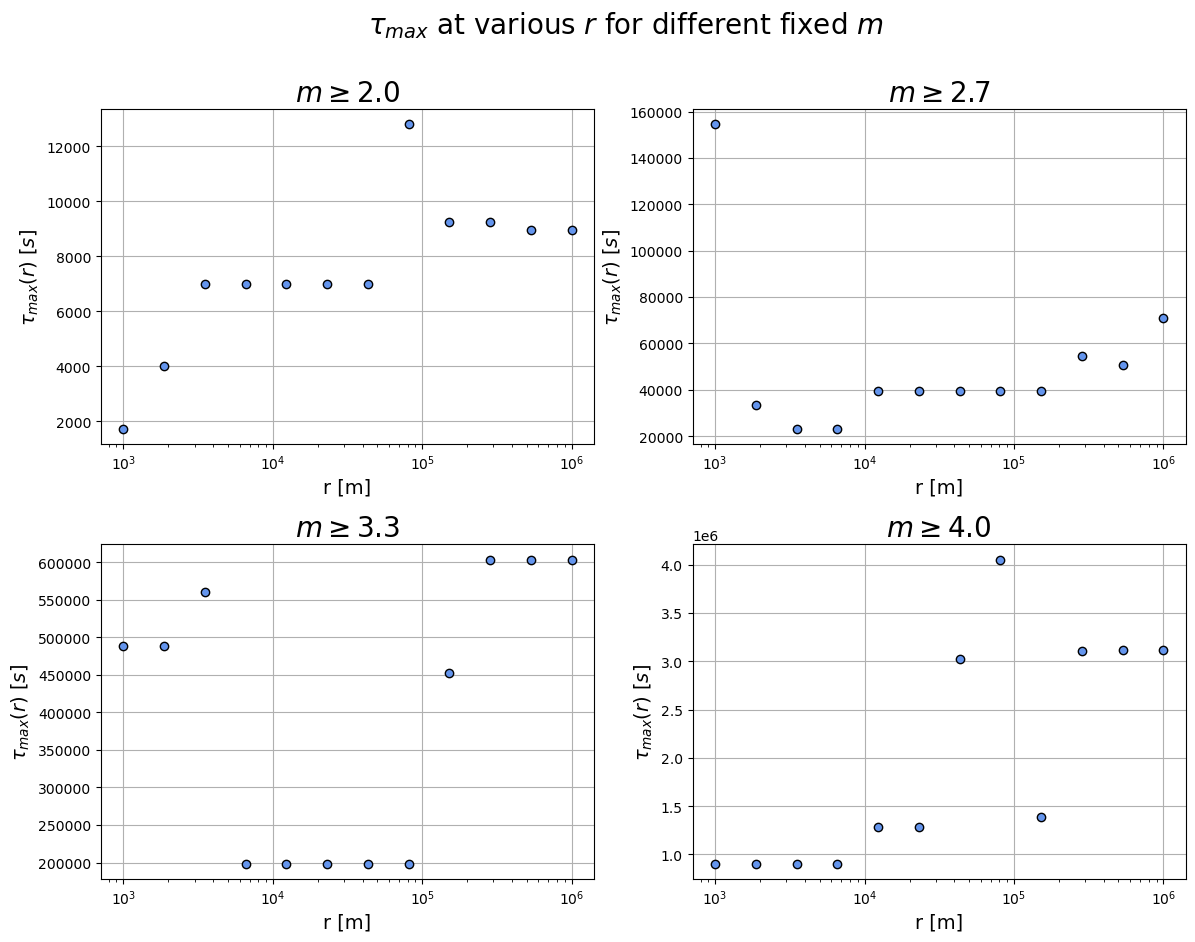

In [42]:
df_wt_mr = df.copy()

list_r = np.logspace(3,6,12)
list_m = np.array([2, 2.7, 3.3, 4,])

fig, ax = plt.subplots(2,2, figsize=(14, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.2)
ax = ax.ravel()
fig.suptitle(r"$\tau_{max}$ at various $r$ for different fixed $m$", fontsize=20)

for i in list_m:
    df_wt_mr['w_Time_m'+str(i)]=df_wt_mr[df_wt_mr['magnitude']>=i]['time'].diff()
    df_wt_mr['diff_x_m'+str(i)]=df_wt_mr[df_wt_mr['magnitude']>=i]['X'].diff()
    df_wt_mr['diff_y_m'+str(i)]=df_wt_mr[df_wt_mr['magnitude']>=i]['Y'].diff()
    df_wt_mr['diff_z_m'+str(i)]=df_wt_mr[df_wt_mr['magnitude']>=i]['Z'].diff()
    df_wt_mr['R_m'+str(i)]=np.sqrt((df_wt_mr['diff_x_m'+str(i)])**2
                                   +(df_wt_mr['diff_y_m'+str(i)])**2
                                   +(df_wt_mr['diff_z_m'+str(i)])**2)

l=0

for i in list_m:

    list_tau_max = []

    for r in list_r:
        
        # logarithmic bins
        logbin = np.logspace(start=math.log(s,b),
                             stop=math.log(df_wt_mr[df_wt_mr['R_m'+str(i)]<r]['w_Time_m'+str(i)].max(),b),
                             base=b, num=n+1)

        # histogram
        counts,bin_edges = np.histogram(df_wt_mr[df_wt_mr['R_m'+str(i)]<r]['w_Time_m'+str(i)], bins=logbin)
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
        bin_widths = bin_edges[1:] - bin_edges[:-1]

        # normalize counts
        norm = np.sum(counts)   
        counts_n = counts/(bin_widths*norm)   

        # filter by removing empty bins for the log-log plot
        counts_n_f = counts_n[counts_n!=0]
        bin_centers_f = bin_centers[counts_n!=0]

        # counts uncertainty ready for the log-log plot
        sigma_counts_n_f_log = counts_uncertainty(counts, bin_widths, norm)

        # select bins and compute linear regression
        start, end = rejecting_algorithm(bin_centers_f, counts_n_f, 60)

        # chi2 goodness of fit test 
        #pvalue = chi2_test(bin_centers_f, counts_n_f, sigma_counts_n_f_log, start, end, par)  

        list_tau_max.append(bin_centers_f[end])


    ax[l].plot(list_r, list_tau_max, 'o', mfc='cornflowerblue', mec='black')
    ax[l].set_ylabel(r'$\tau_{max}(r) \ [s]$', fontsize=14)
    ax[l].set_xlabel('r [m]', fontsize=14)
    ax[l].set_xscale('log')
    ax[l].set_title('$m \geq {}$'.format(i), fontsize=20)
    ax[l].grid()
    l+=1

plt.show()

As we can see, there is no clear dependence between the maximum waiting time $\tau_{max}$ and the distance $r$ at fixed magnitude $m$. Thus, we are unable to find a suitable scaling that also takes distance into account.

## Scaling picture

We plotted different distributions of the waiting time for different $m$ and $r$ as functions of $x=\tau/\tau_{max}(m)$ since we still expect all curves to stop following a power law regime at x = 1 regardless of the cut-off $r$.

We again divided $P_{m,r}(\tau)$ by $k \cdot \tau^{-p}$ where k and p are obtained from a weighted linear regression on a log-log scale using logarithmic binning, ranging from threshold to $\tau_{max}(m)$, which in this case is also affected by the cut-off $r$.

In [43]:
hide_toggle(for_next=True)

In [ ]:
######## UNCOMMENT BELOW TO USE INTERACTIVE BOKEH PLOT #######



"""    df_scaling = df.copy() 

    list_m = [2,3]
    list_r = [5e3, 5e4, 5e5]

    for i in list_m:
        df_scaling['w_Time_m'+str(i)] = df_scaling[df_scaling['magnitude']>=i]['time'].diff()
        df_scaling['diff_x_m'+str(i)] = df_scaling[df_scaling['magnitude']>=i]['X'].diff()
        df_scaling['diff_y_m'+str(i)] = df_scaling[df_scaling['magnitude']>=i]['Y'].diff()
        df_scaling['diff_z_m'+str(i)] = df_scaling[df_scaling['magnitude']>=i]['Z'].diff()
        df_scaling['R_m'+str(i)] = np.sqrt((df_scaling['diff_x_m'+str(i)])**2
                                   +(df_scaling['diff_y_m'+str(i)])**2
                                   +(df_scaling['diff_z_m'+str(i)])**2)


    p = figure(width=800, height=600, x_axis_type="log", y_axis_type="log")
    p.title.text = 'Scaling picture for different m and r'
    p.xaxis.axis_label = r"$$\frac{\tau}{\tau_{max}(m)}$$"
    p.yaxis.axis_label = r"$$\frac{P_{m,r}(\tau)}{k\cdot\tau^{-p}}$$"
    p.title.text_font_size = "28px"
    p.title.text_font = 'sans-serif'
    p.title.text_font_style = 'normal'

    colors = [mcp.gen_color(cmap="Blues", n=len(list_r)+3), mcp.gen_color(cmap="Reds", n=len(list_r)+3), mcp.gen_color(cmap="Greens",n=len(list_r)+3)]

    for r in list_r:

        for i in list_m:
            # theoric tau max 
            tau_max_theo = 10**(f(i, a_tau_max, b_tau_max))


            # logarithmic bins
            logbin = np.logspace(start=math.log(s_scaling,b),
                               stop=math.log(df_scaling[df_scaling['R_m'+str(i)]<r]['w_Time_m'+str(i)].max(),b),
                               base=b, num=n+1)

            # histogram
            counts, bin_edges = np.histogram(df_scaling[df_scaling['R_m'+str(i)]<r]['w_Time_m'+str(i)], bins=logbin)
            bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
            bin_widths = bin_edges[1:] - bin_edges[:-1]

            # normalize counts
            norm = np.sum(counts)       
            counts_n = counts/(bin_widths*norm)

            # filter by removing empty bins for the log-log plot
            counts_n_f = counts_n[counts_n!=0]
            bin_centers_f = bin_centers[counts_n!=0]

            # counts uncertainty ready for the log-log plot
            sigma_counts_n_f_log = counts_uncertainty(counts, bin_widths, norm)

            # fit of the power law
            t_in = 60
            start = np.argmin(np.abs(bin_centers_f - t_in))
            end = np.argmin(np.abs(bin_centers_f - tau_max_theo))

            x_log = np.log10(bin_centers_f[start:end])
            y_log = np.log10(counts_n_f[start:end])
            sigma_y_log = sigma_counts_n_f_log[start:end]
            par, cov = optimize.curve_fit(f, x_log, y_log, sigma=sigma_y_log)

            # scaling of x and y
            x_scaled = bin_centers_f/tau_max_theo
            y_scaled = counts_n_f/(bin_centers_f**par[1]*10**par[0])

            p.line(x_scaled, y_scaled, line_width=2, line_dash='dashed', color=colors[list_r.index(r)][list_m.index(i)+3], legend_label='m = {}, r = {:.0f} m'.format(i, r))
            p.circle(x_scaled, y_scaled, size=6, color=colors[list_r.index(r)][list_m.index(i)+3], legend_label='m = {}, r = {:.0f} m'.format(i, r))

    plt.show()


    p.legend.location = "bottom_left"
    p.legend.click_policy="hide"b


    show(p) """


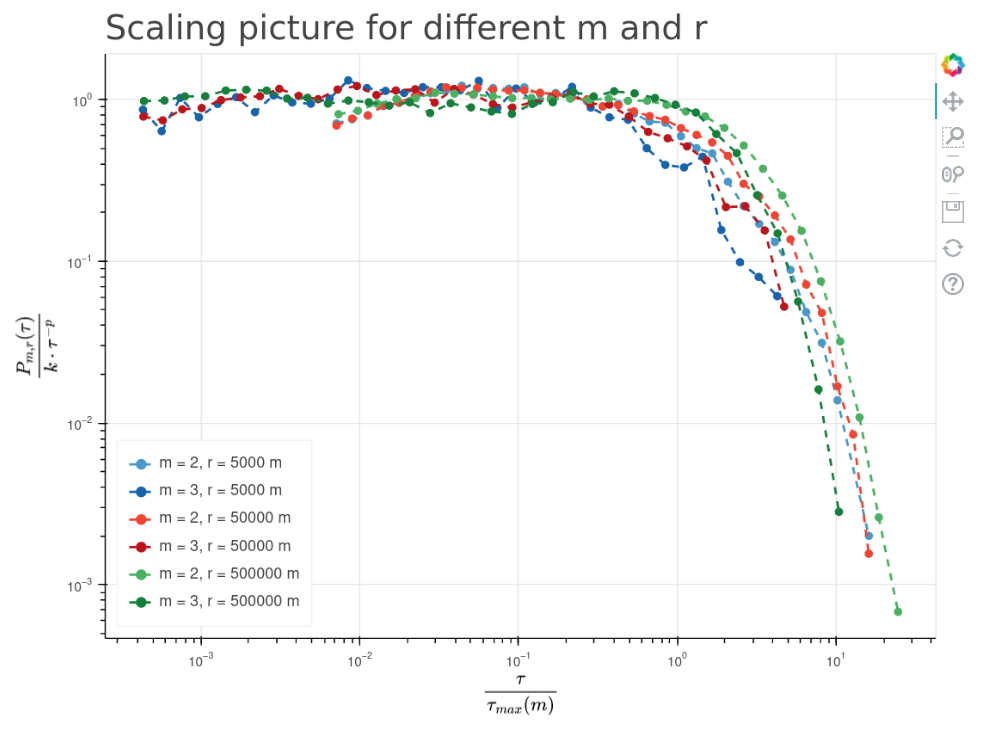

In [51]:
Image('images/bokehscale_mr.png')

In conclusion, it is possible to collapse all distributions for different $m$ and $r$ to a single curve by rescaling the waiting time considering only the dependence on the magnitude $m$.

# Tree structure 

In [45]:
hide_toggle(for_next=True)

In [46]:
nodes = []
for i in range (len(df.index)):
    nodes.append("")

for i in range (len(df.index)):
    if df["trigger"][i] == -1:
        nodes[i] = Node(str(int(df["index"][i])), parent=None)
    else:
        nodes[i] = Node(str(int(df["index"][i])), parent=nodes[int(df["trigger"][i])])


In [47]:
j = 15482 #root to start the tree (not to big)
m = 8830

DotExporter(nodes[j]).to_dotfile(str(j)+".dot")

DotExporter(nodes[m]).to_dotfile(str(m)+".dot")


In [48]:
! dot -Gratio=0.7 -Grotate=90  -Tsvg 15482.dot -o tree.svg
! dot -Gratio=0.7 -Grotate=90  -Tsvg 8830.dot -o treed.svg

In [ ]:
######## UNCOMMENT BELOW TO USE INTERACTIVE BOKEH PLOT #######


#p = figure(x_range=(0, 100), y_range=(0, 100),plot_width=800, plot_height=800)
#p.image_url(url=['tree.svg'], x=0, y=100, w=50, h=100)
#p.image_url(url=['treed.svg'],x=60, y=100,w=40,h=100)
#show(p)